In [1]:
%matplotlib inline 
#%load excesses.py

import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.pyplot as plt

In [2]:
# bring in the data in csv form
filename = "excess-mortality-raw-death-count-9.csv"
data = pd.read_csv(filename)
#print(data.columns)

# Columns
#--------------------------------------
#Entity - United States
#Code - USA
#Day - 2020-08-30
#"Deaths, 2020, all ages" - 56575
#"Average deaths, 2015–2019, all ages"
#deaths_2015_all_ages - 51735
#deaths_2016_all_ages - 51272
#deaths_2017_all_ages - 51272
#deaths_2018_all_ages - 51272
#deaths_2019_all_ages - 51272


In [3]:
# make sure the dates are formatted properly
data["Day"] = pd.to_datetime(data["Day"], format="%Y-%m-%d")

# set Country and Date as indexes
data = data.set_index(["Entity", "Day"]).sort_index()

# rename columns for better readability
data.columns = ["Code", "Average", "2020", "2015", "2016", "2017", "2018", "2019", "2021"]

In [4]:
# pick which columns to keep
data = data[["Average", "2020", "2019", "2018", "2017", "2016", "2015"]]

In [5]:
# Look at only US data
country = data.loc["United States"]
# drops last row because they added part of the next year to the previous year with latest data drops
country = country.copy().drop(country.tail(1).index)
print(country)

            Average     2020     2019     2018     2017     2016     2015
Day                                                                      
2020-01-05  60155.5  60159.0  58461.0  66334.0  59890.0  55937.0      NaN
2020-01-12  60962.2  60714.0  58506.0  67661.0  61108.0  55654.0  61882.0
2020-01-19  59833.2  59344.0  58373.0  64808.0  59444.0  55280.0  61261.0
2020-01-26  58714.0  59144.0  58031.0  62918.0  58174.0  55709.0  58738.0
2020-02-02  58060.2  58809.0  58276.0  61120.0  58530.0  54995.0  57380.0
2020-02-09  58332.4  59445.0  58650.0  61242.0  59155.0  55222.0  57393.0
2020-02-16  57820.4  58792.0  58114.0  59945.0  58596.0  55912.0  56535.0
2020-02-23  57177.8  58877.0  58143.0  57933.0  58376.0  54975.0  56462.0
2020-03-01  56854.0  59301.0  58082.0  56824.0  57354.0  55982.0  56028.0
2020-03-08  57187.4  59675.0  58665.0  57236.0  57590.0  56225.0  56221.0
2020-03-15  56237.0  58655.0  58020.0  56453.0  56772.0  54566.0  55374.0
2020-03-22  55886.8  59187.0  57214.0 

In [6]:
# show the sum over the columns
# dropping the last 2 rows due to incomplete data to compare for 2020
# no longer needed as the data is mostly complete now
#print(country.drop(country.tail(2).index).sum(0))

In [7]:
# show the sum for all rows to compare full year
print(country.sum(0))

Average    2788145.5
2020       3332751.0
2019       2852462.0
2018       2838772.0
2017       2810580.0
2016       2731461.0
2015       2647297.0
dtype: float64


In [8]:
# get amount off the average (excess)
country.loc[:,("2020_excess")] = country["2020"] - country["Average"]
country.loc[:,("2019_excess")] = country["2019"] - country["Average"]
country.loc[:,("2018_excess")] = country["2018"] - country["Average"]

# show excess percents
country.loc[:,("2020_excess_percent")] = country["2020_excess"] / country["Average"] * 100

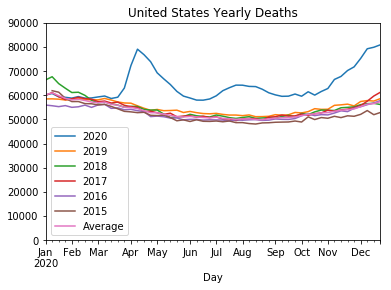

In [9]:
# plot graph of yearly deaths
fig, ax = plt.subplots()
plt.title("United States Yearly Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d/%Y'))
country.plot(y=["2020", "2019", "2018", "2017", "2016","2015", "Average"], kind="line", ax=ax, ylim=(0, 90000))
plt.show()

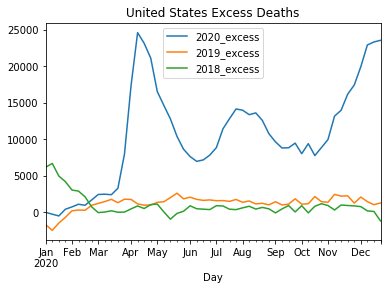

In [10]:
fig, ax = plt.subplots()
plt.title("United States Excess Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter("%m/%d/%Y"))
country.plot(y=["2020_excess", "2019_excess", "2018_excess"], kind="line", ax=ax)
plt.show()

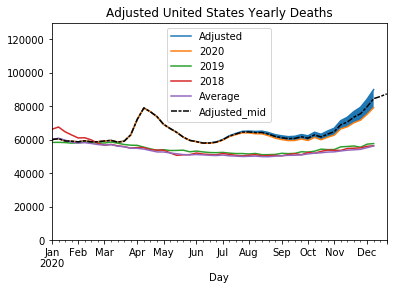

In [11]:
# probabilistic scale factor for possible deaths not yet reported
# https://www.cdc.gov/nchs/data/vsrr/report001.pdf
prob = [
        86.0, 86.9, 88.0, 89.3, 90.3, 91.3, 92.2,
        93.1, 93.8, 94.3, 94.8, 95.2, 95.5, 95.8,
        96.0, 96.2, 96.4, 96.7, 97.1, 97.5, 97.9,
        98.3, 98.6, 98.9, 99.1, 99.3, 99.5, 99.6,
        99.7, 99.8, 99.9, 99.9, 99.9, 100.0, 100.0,
        100.0, 100.0, 100.0, 100.0, 100.0,
        100.0, 100.0, 100.0, 100.0,
        100.0, 100.0, 100.0, 100.0,
        100.0, 100.0, 100.0, 100.0
]

# Add column for probabilistic death count
adjusted = prob
country["Reported"] = np.array(adjusted[-1:-53:-1])
country["Adjusted"] = (country["2020"].fillna(0) / country["Reported"] * 100.0).fillna(0).astype(int)
country["Adjusted_excess"] = country["Adjusted"] - country["Average"]
country["Adjusted_excess_percent"] = country["Adjusted_excess"] / country["Average"] * 100

country["Adjusted_mid"] = (country["Adjusted"] + country["2020"]) / 2

fig, ax = plt.subplots()
plt.title("Adjusted United States Yearly Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d/%Y'))
drop_index = country.tail(2).index
country.drop(drop_index).plot(y=["Adjusted", "2020", "2019", "2018", "Average"], kind="line", ax=ax)
ax.fill_between(country.drop(drop_index).index, country.drop(drop_index)["2020"], country.drop(drop_index)["Adjusted"])
country.plot(y="Adjusted_mid", kind="line", dashes=[4,1,2,1], color="black", ax=ax, ylim=(0, 130000))
plt.show()

In [12]:
print(country[["2020", "2019", "2018", "Average", "Reported"]])

               2020     2019     2018  Average  Reported
Day                                                     
2020-01-05  60159.0  58461.0  66334.0  60155.5     100.0
2020-01-12  60714.0  58506.0  67661.0  60962.2     100.0
2020-01-19  59344.0  58373.0  64808.0  59833.2     100.0
2020-01-26  59144.0  58031.0  62918.0  58714.0     100.0
2020-02-02  58809.0  58276.0  61120.0  58060.2     100.0
2020-02-09  59445.0  58650.0  61242.0  58332.4     100.0
2020-02-16  58792.0  58114.0  59945.0  57820.4     100.0
2020-02-23  58877.0  58143.0  57933.0  57177.8     100.0
2020-03-01  59301.0  58082.0  56824.0  56854.0     100.0
2020-03-08  59675.0  58665.0  57236.0  57187.4     100.0
2020-03-15  58655.0  58020.0  56453.0  56237.0     100.0
2020-03-22  59187.0  57214.0  55904.0  55886.8     100.0
2020-03-29  62987.0  56800.0  55038.0  54997.2     100.0
2020-04-05  72269.0  56710.0  55412.0  54935.0     100.0
2020-04-12  79066.0  55625.0  55347.0  54465.4     100.0
2020-04-19  76766.0  54616.0  5